In [7]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

In [10]:
# Папки
input_folder = 'data\\FINALE\\masks'     # путь к папке с исходными изображениями
output_folder = 'data\\FINALE\\masks_crop'  # путь для сохранения обрезанных

# Координаты кропа: [y1:y2, x1:x2]
def pre_crop(image, crop_y1, crop_y2, crop_x1, crop_x2):
    img_crop = image[crop_y1:crop_y2, crop_x1:crop_x2]
    return img_crop
crop_y1, crop_y2 = 100, 808
crop_x1, crop_x2 = 40, 1030

# Создать папку, если не существует
os.makedirs(output_folder, exist_ok=True)

# Обработка изображений
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        path = os.path.join(input_folder, filename)
        img = cv2.imread(path)

        if img is None:
            print(f"Не удалось загрузить {filename}")
            continue

        img_crop = pre_crop(img, crop_y1, crop_y2, crop_x1, crop_x2)
        cv2.imwrite(os.path.join(output_folder, filename), img_crop)

print("Кроп завершён.")


Кроп завершён.


In [8]:
import os

# Кроп параметры
crop_top, crop_bottom = 100, 808
crop_left, crop_right = 40, 1030
crop_width = crop_right - crop_left
crop_height = crop_bottom - crop_top

# Пути
labels_input_dir = 'data\\FINALE\\texts'
labels_output_dir = 'data\\FINALE\\texts_crop'

os.makedirs(labels_output_dir, exist_ok=True)

def adjust_yolo_bbox(cls, x, y, w, h, img_w, img_h):
    abs_x = x * img_w
    abs_y = y * img_h
    abs_w = w * img_w
    abs_h = h * img_h

    x1 = abs_x - abs_w / 2
    y1 = abs_y - abs_h / 2
    x2 = abs_x + abs_w / 2
    y2 = abs_y + abs_h / 2

    x1 -= crop_left
    x2 -= crop_left
    y1 -= crop_top
    y2 -= crop_top

    if x2 <= 0 or y2 <= 0 or x1 >= crop_width or y1 >= crop_height:
        return None

    x1 = max(0, min(x1, crop_width))
    x2 = max(0, min(x2, crop_width))
    y1 = max(0, min(y1, crop_height))
    y2 = max(0, min(y2, crop_height))

    new_w = x2 - x1
    new_h = y2 - y1
    new_x = x1 + new_w / 2
    new_y = y1 + new_h / 2

    return f"{cls} {new_x / crop_width:.6f} {new_y / crop_height:.6f} {new_w / crop_width:.6f} {new_h / crop_height:.6f}"

# Обработка всех .txt файлов
for filename in os.listdir(labels_input_dir):
    if not filename.endswith(".txt"):
        continue

    input_path = os.path.join(labels_input_dir, filename)
    output_path = os.path.join(labels_output_dir, filename)

    with open(input_path, 'r') as infile:
        lines = infile.readlines()

    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue

        cls, x, y, w, h = parts
        adjusted = adjust_yolo_bbox(
            cls, float(x), float(y), float(w), float(h),
            img_w=1164,  # ← оригинальная ширина
            img_h=873   # ← оригинальная высота
        )
        if adjusted:
            new_lines.append(adjusted)

    with open(output_path, 'w') as outfile:
        outfile.write('\n'.join(new_lines))

print("Разметка обновлена под кроп.")


Разметка обновлена под кроп.


In [7]:
import os
import cv2
from collections import Counter

# Папка с изображениями
folder = 'data\\FINALE\\images'  # укажи путь к папке

# Поддерживаемые форматы
extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

# Счётчик размеров
size_counter = Counter()
total_images = 0

# Перебор файлов
for filename in os.listdir(folder):
    if filename.lower().endswith(extensions):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is None:
            print(f"⚠️ Проблема с файлом: {filename}")
            continue
        h, w = img.shape[:2]
        size_counter[(w, h)] += 1
        total_images += 1

# Вывод результата
print(f"Всего изображений: {total_images}\n")
print("Размеры изображений и количество каждого:")
for (w, h), count in size_counter.items():
    print(f"🖼 {w}x{h} — {count} шт.")


Всего изображений: 225

Размеры изображений и количество каждого:
🖼 1164x873 — 220 шт.
🖼 800x600 — 4 шт.
🖼 1295x913 — 1 шт.


In [26]:
import os
import cv2
import math

# Параметры
input_folder = 'data\\FINALE\\masks_check'
output_folder = 'data\\FINALE\\masks_scaled'
target_width = 1164
target_height = 873
target_ratio = target_width / target_height
tolerance = 0.01  # допустимая погрешность в соотношении сторон

# Создание папки, если не существует
os.makedirs(output_folder, exist_ok=True)

# Обработка изображений
saved = 0
skipped = 0

for filename in os.listdir(input_folder):
    if not filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
        continue

    path = os.path.join(input_folder, filename)
    img = cv2.imread(path)

    if img is None:
        print(f"⚠️ Невозможно загрузить {filename}")
        continue

    h, w = img.shape[:2]
    ratio = w / h

    if math.isclose(ratio, target_ratio, rel_tol=tolerance):
        resized = cv2.resize(img, (target_width, target_height))
        cv2.imwrite(os.path.join(output_folder, filename), resized)
        saved += 1
    else:
        skipped += 1
        print(path)

print(f"✅ Готово: сохранено {saved} изображений, пропущено {skipped}.")


data\FINALE\masks_check\95_64.png
✅ Готово: сохранено 224 изображений, пропущено 1.


In [4]:
img.shape

(873, 1164, 3)

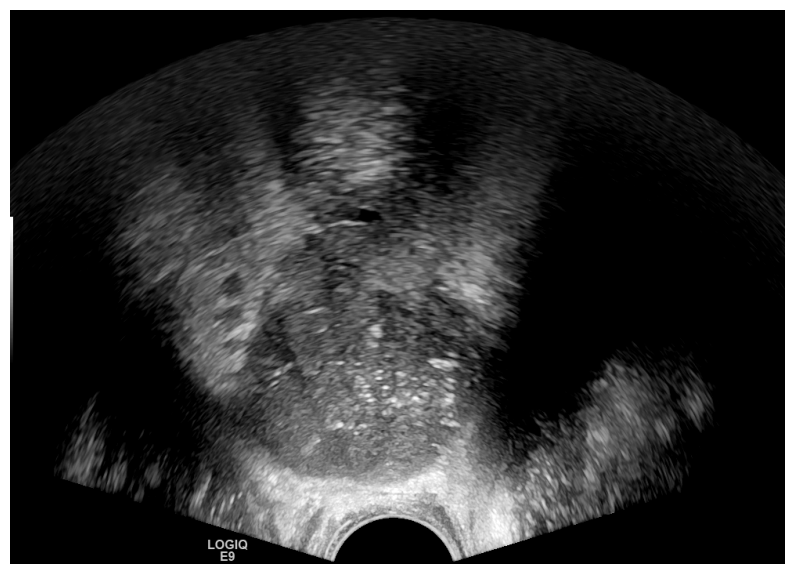

In [2]:
img = cv.imread('data\\sech_2\\2024.04.05\\Image30.jpg')
img_crop = img[100:808, 40:1030]
plt.figure(figsize=(10, 10))
plt.imshow(img_crop)
plt.axis('off')
plt.show()

In [7]:
img_crop.shape

(708, 990, 3)

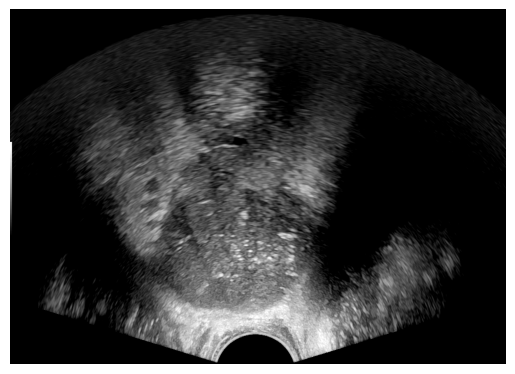

In [3]:
color = (0, 0, 0)  
thickness = -1  
cv.rectangle(img_crop, (0, 675), (305, 708), color, thickness)
plt.imshow(img_crop)
plt.axis('off')
plt.show()

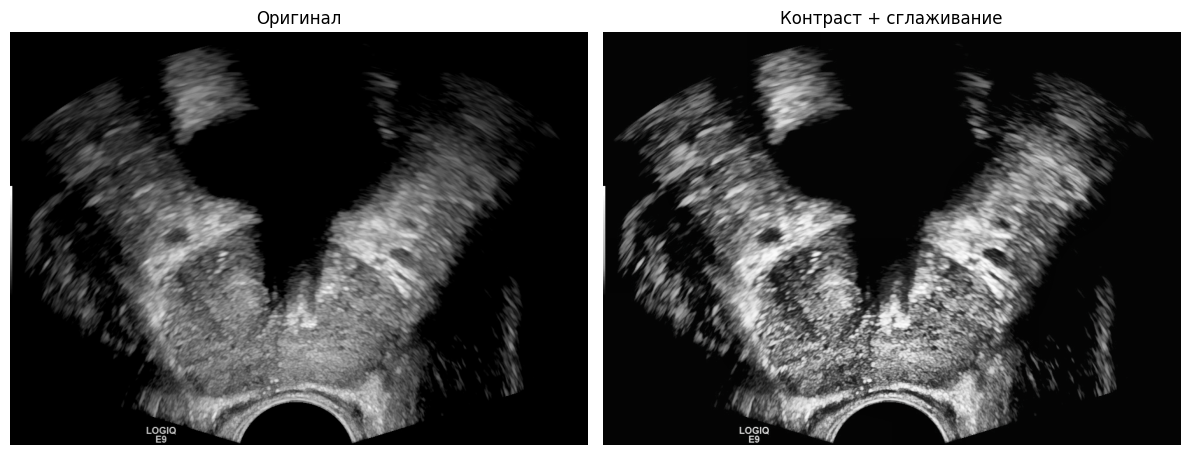

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def enhance_contrast(image_path, output_path=None, clip_limit=2.0, tile_grid_size=(8, 8),
                     apply_blur=True, blur_kernel_size=(7, 7), show=True):
    """
    Повышает контрастность изображения с использованием CLAHE, применяет сглаживание и отображает результат.

    Параметры:
    - image_path (str): путь к входному изображению.
    - output_path (str, optional): путь для сохранения результата. Если None — не сохраняется.
    - clip_limit (float): ограничение контраста для CLAHE.
    - tile_grid_size (tuple): размер сетки для локального выравнивания гистограммы.
    - apply_blur (bool): применять ли гауссово сглаживание после CLAHE.
    - blur_kernel_size (tuple): размер ядра для сглаживания.
    - show (bool): отображать ли результат.

    Возвращает:
    - result (np.ndarray): итоговое изображение.
    """

    # Загрузка и проверка изображения
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Изображение не найдено: {image_path}")

    # Перевод в LAB и CLAHE
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    result = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # Применение сглаживания
    if apply_blur:
        result = cv2.GaussianBlur(result, blur_kernel_size, sigmaX=0)

    # Сохранение
    if output_path:
        cv2.imwrite(output_path, result)

    # Отображение
    if show:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Оригинал")
        plt.imshow(image_rgb)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Контраст + сглаживание")
        plt.imshow(result_rgb)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return result

# enhance_contrast('1.png', '1_enh.png')
img_enh = enhance_contrast('data\\images_crop\\6_10.jpg', apply_blur=False)

In [61]:
import os
import cv2
import numpy as np

def enhance_contrast(image_path, output_path=None, clip_limit=2.0, tile_grid_size=(8, 8)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Изображение не найдено: {image_path}")

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    result = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    if output_path:
        cv2.imwrite(output_path, result)

    return result

def process_folder(input_dir, output_dir, extensions=(".jpg", ".jpeg", ".png", ".bmp")):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(extensions):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            try:
                enhance_contrast(input_path, output_path)
                print(f"Обработано: {filename}")
            except Exception as e:
                print(f"Ошибка при обработке {filename}: {e}")

# Пример использования
input_folder = "data/images_crop"
output_folder = "data/images_enhanced"
process_folder(input_folder, output_folder)


Обработано: 0_6.jpg
Обработано: 100_67.jpg
Обработано: 101_67.jpg
Обработано: 102_68.jpg
Обработано: 103_69.jpg
Обработано: 104_69.jpg
Обработано: 106_71.jpg
Обработано: 107_71.jpg
Обработано: 108_72.jpg
Обработано: 109_72.jpg
Обработано: 10_13.jpg
Обработано: 110_73.jpg
Обработано: 111_73.jpg
Обработано: 112_74.jpg
Обработано: 113_75.jpg
Обработано: 114_76.jpg
Обработано: 115_76.jpg
Обработано: 116_77.jpg
Обработано: 117_77.jpg
Обработано: 118_77.jpg
Обработано: 119_78.jpg
Обработано: 11_14.jpg
Обработано: 120_78.jpg
Обработано: 121_78.jpg
Обработано: 122_79.jpg
Обработано: 123_79.jpg
Обработано: 124_79.jpg
Обработано: 125_80.jpg
Обработано: 126_80.jpg
Обработано: 127_80.jpg
Обработано: 128_81.jpg
Обработано: 129_82.jpg
Обработано: 12_15.jpg
Обработано: 130_82.jpg
Обработано: 131_83.jpg
Обработано: 132_83.jpg
Обработано: 133_83.jpg
Обработано: 134_84.jpg
Обработано: 135_84.jpg
Обработано: 136_85.jpg
Обработано: 137_86.jpg
Обработано: 138_86.jpg
Обработано: 13_18.jpg
Обработано: 140_87

In [53]:
import os
import cv2
import numpy as np

def find_clean_global_roi(masks_folder, min_pixel_threshold=100):
    combined_mask = None

    for filename in os.listdir(masks_folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            path = os.path.join(masks_folder, filename)
            mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

            if combined_mask is None:
                combined_mask = np.zeros_like(mask, dtype=np.uint8)

            # Бинаризация (гарантируем чёрно-белую маску)
            _, binary = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
            combined_mask += binary  # суммируем в одну общую маску

    if combined_mask is None or np.count_nonzero(combined_mask) == 0:
        print("Маски пусты или не найдены.")
        return None

    # Обнуляем пиксели ниже порога (если пиксель был активен на слишком малом числе масок)
    combined_mask = (combined_mask >= min_pixel_threshold).astype(np.uint8)

    # Находим координаты активных пикселей
    ys, xs = np.where(combined_mask > 0)
    if len(xs) == 0 or len(ys) == 0:
        print("После фильтрации остались только шумы.")
        return None

    x0, y0 = xs.min(), ys.min()
    x1, y1 = xs.max(), ys.max()
    return [int(x0), int(y0), int(x1), int(y1)]


roi = find_clean_global_roi("data\\images_crop")
print("Корректный минимальный ROI:", roi)

Корректный минимальный ROI: [0, 265, 729, 703]


# SAM

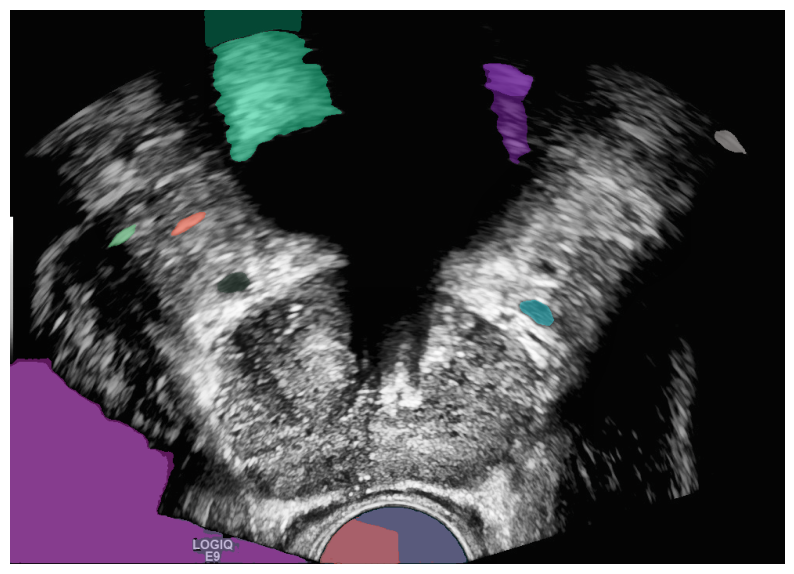

CPU times: total: 28.8 s
Wall time: 29.9 s


In [60]:
%%time
# image_path = "data\\images_crop\\0_6.jpg"  
sam_checkpoint = "sam_vit_l_0b3195.pth"  # sam_vit_b_01ec64.pth  /////   sam_vit_h_4b8939.pth //// sam_vit_l_0b3195.pth
model_type = "vit_l"  #  vit_h ///// vit_b /////vit_l

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

sam.to("cuda")  


mask_generator = SamAutomaticMaskGenerator(sam)

# image = cv2.imread(image_path)
image = img_enh
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # Конвертируем BGR в RGB для SAM

masks = mask_generator.generate(image)

def overlay_masks(image, masks):
    overlay = image.copy()
    for mask in masks:
        color = np.random.randint(0, 255, size=3, dtype=np.uint8)
        overlay[mask['segmentation']] = overlay[mask['segmentation']] * 0.5 + color * 0.5
    return overlay

segmented_image = overlay_masks(image, masks)
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image)
plt.axis('off')
plt.show()

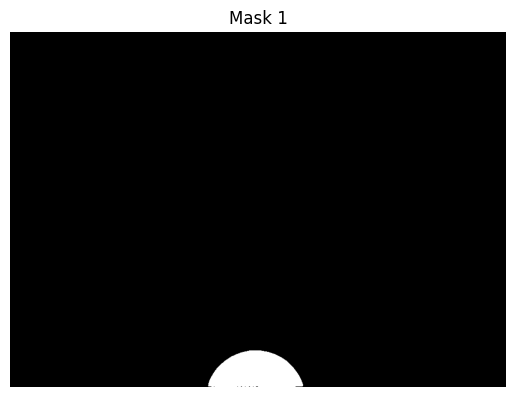

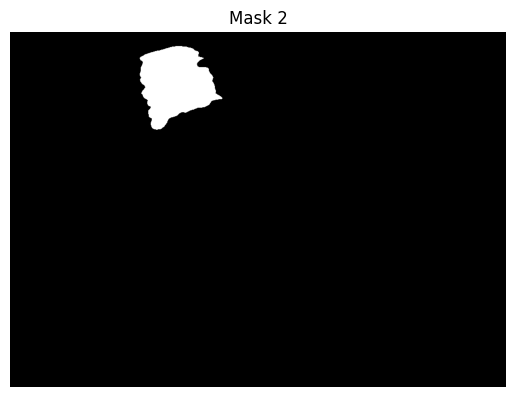

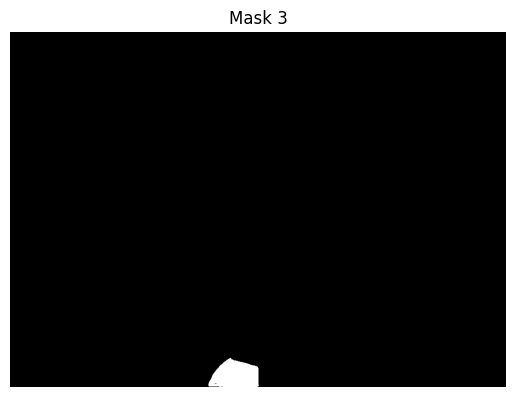

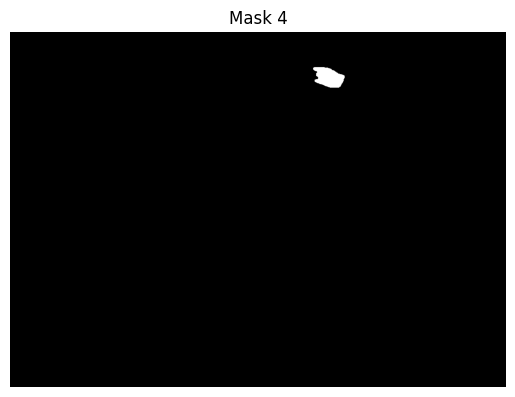

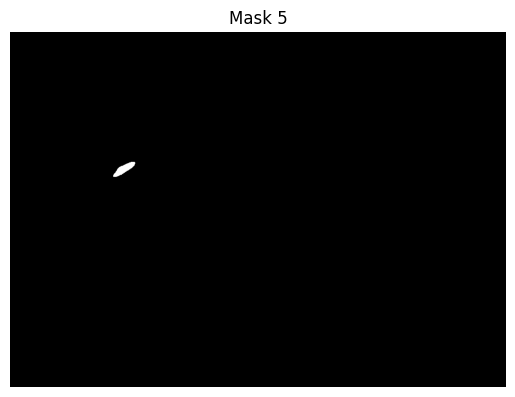

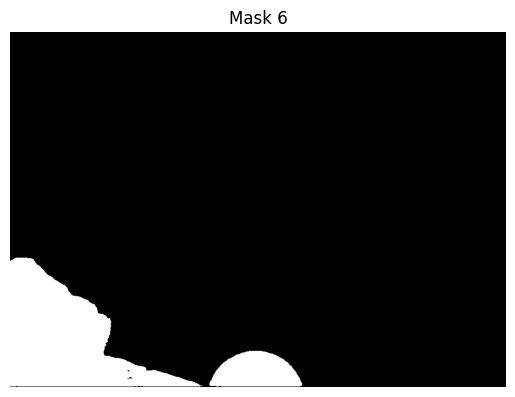

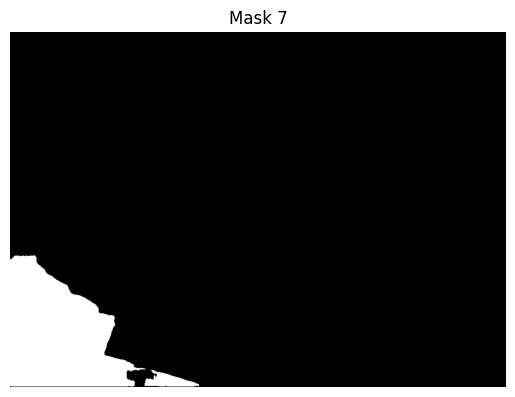

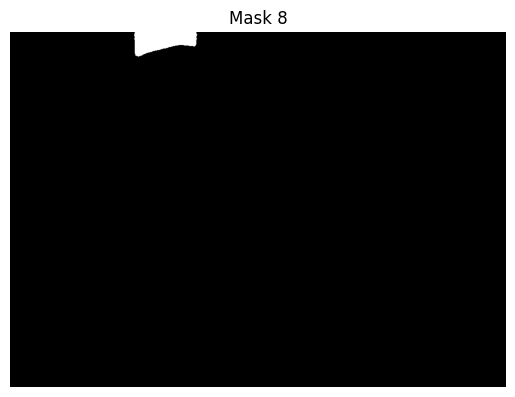

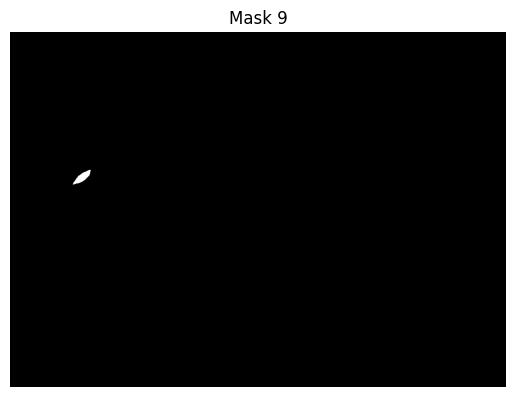

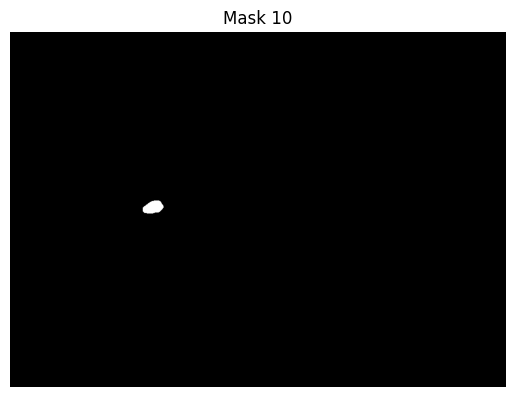

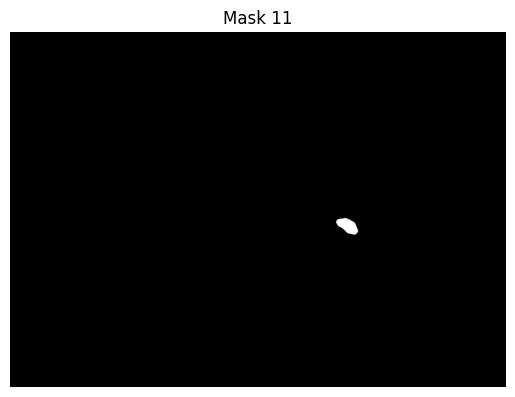

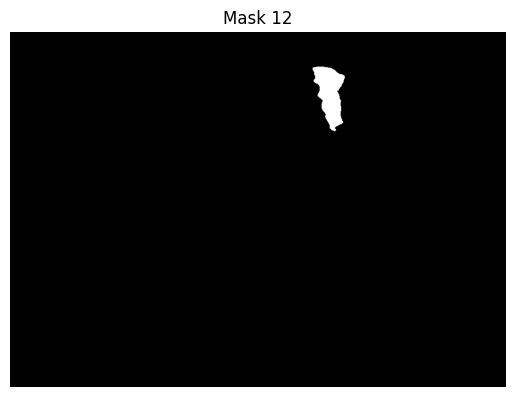

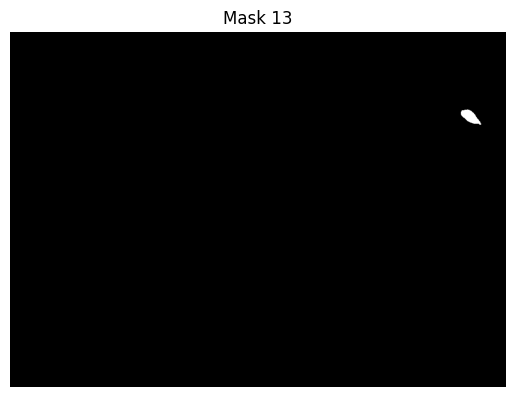

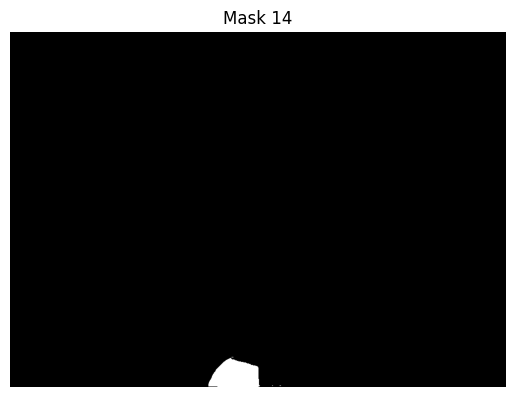

In [62]:
import matplotlib.pyplot as plt
import numpy as np

def show_binary_masks(masks):
    for i, mask in enumerate(masks):
        binary_mask = np.zeros_like(mask['segmentation'], dtype=np.uint8)
        binary_mask[mask['segmentation']] = 255

        plt.figure()
        plt.title(f"Mask {i+1}")
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')
        plt.show()
show_binary_masks(masks)

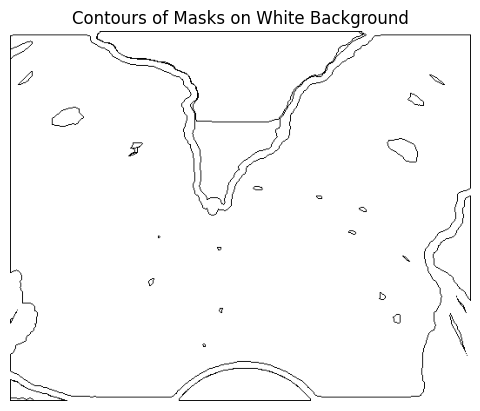

In [74]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_mask_contours(masks, erosion_kernel_size=5):
    if not masks:
        return np.ones((0, 0), dtype=np.uint8) * 255  # белый фон

    height, width = masks[0]['segmentation'].shape
    canvas = np.ones((height, width), dtype=np.uint8) * 255  # белый фон
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (erosion_kernel_size, erosion_kernel_size))

    for mask in masks:
        binary_mask = np.zeros_like(mask['segmentation'], dtype=np.uint8)
        binary_mask[mask['segmentation']] = 255

        # Эрозия для создания зазора
        eroded_mask = cv2.erode(binary_mask, kernel, iterations=1)

        # Поиск контуров
        contours, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Рисуем контуры чёрным цветом
        cv2.drawContours(canvas, contours, -1, color=0, thickness=1)

    return canvas

def show_contour_mask(mask_with_contours):
    plt.figure()
    plt.title("Contours of Masks on White Background")
    plt.imshow(mask_with_contours, cmap='gray')
    plt.axis('off')
    plt.show()

# Пример вызова:
contour_mask = draw_mask_contours(masks, erosion_kernel_size=5)
show_contour_mask(contour_mask)

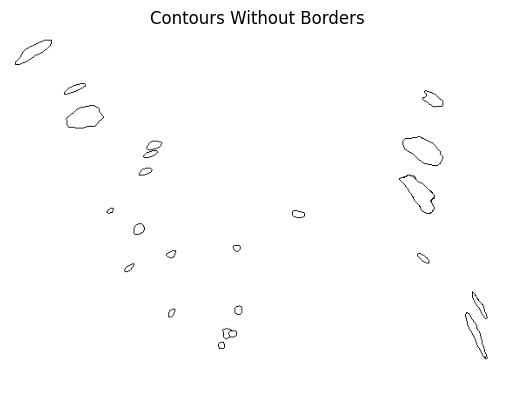

In [76]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_clean_mask_contours(masks):
    if not masks:
        return np.ones((0, 0), dtype=np.uint8) * 255  # белый фон

    height, width = masks[0]['segmentation'].shape
    canvas = np.ones((height, width), dtype=np.uint8) * 255  # белый фон

    for mask in masks:
        binary_mask = np.zeros_like(mask['segmentation'], dtype=np.uint8)
        binary_mask[mask['segmentation']] = 255

        # Находим только внутренние контуры, исключая рамку по краям
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            # Проверяем: есть ли точка на границе изображения — если да, пропускаем
            if np.any(cnt == 0) or np.any(cnt[:, :, 0] == width - 1) or np.any(cnt[:, :, 1] == height - 1):
                continue  # пропускаем контуры, касающиеся краёв

            # Рисуем контур чёрным цветом
            cv2.drawContours(canvas, [cnt], -1, color=0, thickness=1)

    return canvas

def show_contour_mask(mask_with_contours):
    plt.figure()
    plt.title("Contours Without Borders")
    plt.imshow(mask_with_contours, cmap='gray')
    plt.axis('off')
    plt.show()

# Пример вызова:
contour_mask = draw_clean_mask_contours(masks)
show_contour_mask(contour_mask)


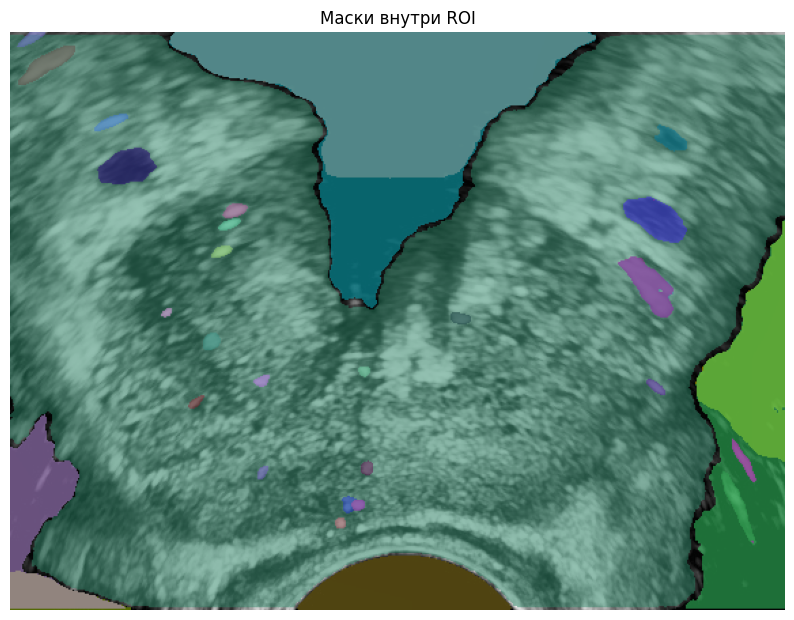

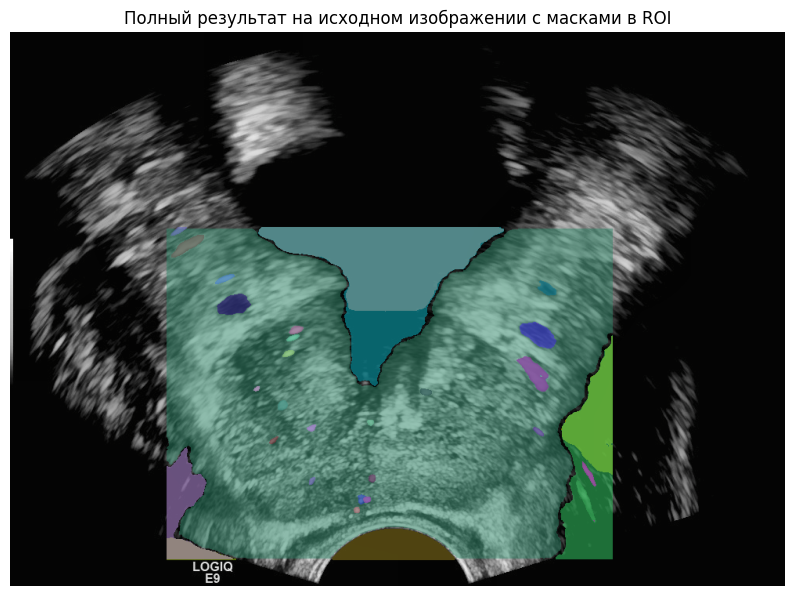

In [75]:
from segment_anything import SamPredictor, SamAutomaticMaskGenerator
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

# Подгрузка модели
sam_checkpoint = "sam_vit_l_0b3195.pth"
model_type = "vit_l"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to("cuda")

# Загрузка изображения
image = img_enh  # или cv2.imread(...)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # Конвертируем в RGB

# Указываем ROI в формате [x0, y0, x1, y1]
input_box = np.array([200, 250, 770, 675])

# Обрезка изображения на основе ROI
roi_image = image_rgb[input_box[1]:input_box[3], input_box[0]:input_box[2]]

# Создание генератора масок для предсказаний
mask_generator = SamAutomaticMaskGenerator(sam)

# Генерация масок на основе обрезанного изображения
masks = mask_generator.generate(roi_image)

# Функция наложения масок
def overlay_masks(image, masks):
    overlay = image.copy()
    for mask in masks:
        color = np.random.randint(0, 255, size=3, dtype=np.uint8)
        overlay[mask['segmentation']] = overlay[mask['segmentation']] * 0.5 + color * 0.5
    return overlay

# Наложение масок на ROI
segmented_image = overlay_masks(roi_image, masks)

# Визуализация масок внутри ROI
plt.figure(figsize=(10, 10))
plt.title("Маски внутри ROI")
plt.imshow(segmented_image)
plt.axis('off')
plt.show()

# Восстановление результата на исходном изображении, если нужно
full_overlay = image.copy()
full_overlay[input_box[1]:input_box[3], input_box[0]:input_box[2]] = segmented_image

# Визуализация полного результата на исходном изображении
plt.figure(figsize=(10, 10))
plt.title("Полный результат на исходном изображении с масками в ROI")
plt.imshow(full_overlay)
plt.axis('off')
plt.show()


In [6]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.8


In [92]:
import os
import cv2
import numpy as np
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry
from tqdm import tqdm

# Конфигурация
sam_checkpoint = "sam_vit_l_0b3195.pth"
model_type = "vit_l"
device = "cuda"

input_folder = "data\\images_enhanced"
output_folder = "data\\images_enhanced_sam"
roi_box = [200, 250, 770, 675]  # [x0, y0, x1, y1]
contour_thickness = 2
alpha_value = 128  # Прозрачность (0 = прозрачно, 1 = непрозрачно)
border_dist = 15

# Инициализация SAM
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
mask_generator = SamAutomaticMaskGenerator(sam)

os.makedirs(os.path.join(output_folder, "images_with_contours"), exist_ok=True)
os.makedirs(os.path.join(output_folder, "only_contours"), exist_ok=True)

def draw_contour_overlay(masks, shape, thickness=2, border_dist=15):
    h, w = shape
    contour_layer = np.zeros((h, w), dtype=np.uint8)

    for mask in masks:
        binary_mask = np.zeros((h, w), dtype=np.uint8)
        binary_mask[mask['segmentation']] = 255

        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            # if np.any(cnt == 0) or np.any(cnt[:, :, 0] == w - 1) or np.any(cnt[:, :, 1] == h - 1):
            #     continue
            cv2.drawContours(contour_layer, [cnt], -1, color=255, thickness=thickness)
        
        contour_layer[:border_dist, :] = 0  # верхняя граница
        contour_layer[-border_dist:, :] = 0  # нижняя граница
        contour_layer[:, :border_dist] = 0  # левая граница
        contour_layer[:, -border_dist:] = 0 
        
    return contour_layer

def create_alpha_contour_overlay(image_gray, contour_mask, alpha_value=128):
    # Преобразуем grayscale в RGB
    image_rgb = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR)

    # Создаём пустую альфа-маску
    h, w = contour_mask.shape
    overlay_rgba = np.zeros((h, w, 4), dtype=np.uint8)
    overlay_rgba[:, :, :3] = 255  # Белый фон
    overlay_rgba[:, :, 3] = 0     # Полностью прозрачный по умолчанию

    # Применим чёрный цвет и альфа только по контурам
    overlay_rgba[contour_mask > 0] = [0, 0, 0, alpha_value]

    # Конвертируем исходное изображение в RGBA
    base_rgba = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2BGRA)

    # Наложение альфа-маски
    result = base_rgba.copy()
    mask_alpha = overlay_rgba[:, :, 3] / 255.0
    for c in range(3):  # только RGB
        result[:, :, c] = result[:, :, c] * (1 - mask_alpha) + overlay_rgba[:, :, c] * mask_alpha

    return result.astype(np.uint8)

def process_image(image_path):
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    roi = image_rgb[roi_box[1]:roi_box[3], roi_box[0]:roi_box[2]]
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    masks = mask_generator.generate(roi)
    h, w = roi.shape[:2]

    contour_mask = draw_contour_overlay(masks, (h, w), thickness=contour_thickness, border_dist = 15)

    # Финальное изображение с наложенными контурами внутри ROI
    final_roi_overlay = create_alpha_contour_overlay(roi_gray, contour_mask, alpha_value=128)

    # Подготовка полного изображения с ROI, в который мы вставим итог
    full_result = image_bgr.copy()
    full_result[roi_box[1]:roi_box[3], roi_box[0]:roi_box[2]] = final_roi_overlay[:, :, :3]

    # Чистое изображение только контуров (белый фон + чёрные линии)
    only_contours = np.ones((h, w), dtype=np.uint8) * 255
    only_contours[contour_mask > 0] = 0

    return full_result, only_contours


# Обработка всех изображений в папке
for filename in tqdm(os.listdir(input_folder)):
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    input_path = os.path.join(input_folder, filename)
    image_with_overlay, only_contours = process_image(input_path)

    cv2.imwrite(os.path.join(output_folder, "images_with_contours", filename), image_with_overlay)
    cv2.imwrite(os.path.join(output_folder, "only_contours", filename), only_contours)


100%|██████████████████████████████████████████████████████████████████████████████| 232/232 [1:45:02<00:00, 27.17s/it]
